In [1]:
from astropy import units as u
from astropy import constants as c
from numbers import Number
import numpy as np
import scipy as sp
import scipy.optimize as spopt
import scipy.linalg as spla
import scipy.sparse.linalg as spsla
from scipy.sparse import csr_matrix
import spdlog as spd
import warnings
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib nbagg
np.set_printoptions(edgeitems=5, linewidth=165, precision=5)

# Class & Functions for Coagulation

If the size of solid particles follows a power law
$$ \frac{dN}{da} \propto a^{-q}, $$
where $q = 3.5$, then equivalently, their mass distribution follows the power law
$$ \frac{dN}{dm} \propto m^{-p}, $$
where $p = 11/6$ because $q = 3p - 2$. However, we perform our calculations on the logrithmic axis, so
$$ \frac{dN}{da} \propto a^{-q} \Rightarrow \frac{dN}{d\log a} \propto a^{-(q-1)}, $$
where $q-1=2.5$.

---  
In order to trace the size and radial evolution of dust in a combined way, Birstiel+2010 expresses all contributing processes in terms of the same quantity. More specifically, Birstiel+2010 formulates the coagulation/fragmentation equation in a vertically integrated way. The most common quantity used is the vertically integrated dust surface density distribution **per logarithmic bin of grain radius**,
$$ \sigma(r, a) = \int_{-\infty}^{\infty} n(r, z, a) \cdot m \cdot a\ dz, \ \ \ \Rightarrow\ \ \  \rho(r, z) = \int_0^\infty n(m, r, z)\cdot m\ dm, \ \ \ \Sigma_{\rm d}(r) = \int_0^\infty \sigma(r, a)\ d\ln a, \ \ \ (\text{i.e.,}\ \sigma(r, a) = \frac{d\Sigma_{\rm d}(r, a)}{d\ln a}) $$
where $n(r, z, a)\equiv dN/da$ and $n(r, z, m)\equiv dN/dm$ are related through $m = 4\pi/3\rho_{\rm s} a^3$, $n(r, z, a) da = n(r, z, m) dm$, and $dm/da = 3m/a$ (or $d\log m = 3d\log a$). If $q = 3.5$, then
$$\sigma(a) \propto n(a) \cdot m \cdot a \propto a^{-s} \propto a^{-q+4} \propto a^{0.5}, $$
where the power law index is $s = q - 4$. The units of $\sigma(r, a)$ is g/cm$^2$, just like $\Sigma_{\rm d}$. The units of $n(r, z, a)$ is 1/cm$^3$/cm, the units of $n(r, z, m)$ is 1/cm$^3$/g.

When discretizing the Smoluchowski equation
$$ \frac{\partial}{\partial t}n(m, r, z) = \int\int_0^\infty M(m, m', m'')\times n(m', r, z)\cdot n(m'', r, z) dm' dm'', $$
on a mass grid $m_i$
$$ \frac{\partial}{\partial t}n_k(r, z) = \sum_{i,j} M_{i,j,k}n_i(r,z)n_j(r,z),\ \ \ \text{where}\ n_i(r,z) = \int_{m_{i-1/2}}^{m_{i+1/2}} n(m, r, z) dm \left[ = \int_{a_{i-1/2}}^{a_{i+1/2}} n(a, r, z) da\right]. $$
**Note that** in the discretized equation, the units of $n_i(r, z)$ changes to 1/cm$^3$ due to the integration over the cell.

To make it vertically integrated before solving, assuming the coagulation/fragmentation kernels are constant in $z$ and the solid vertical distribution is a Gaussian with a scale height $h$,
$$ \begin{aligned}
  n_k(r, z) &= \frac{N_k(r)}{\sqrt{2\pi} h_k(r)} \cdot \exp\left(-\frac{z^2}{2h_k(r)^2} \right), \\
  \frac{\partial}{\partial t}N_k(r) &= \int_{-\infty}^\infty \dot{n}_k dz = \sum_{i,j} M_{i,j,k} N_i(r) N_j(r) \frac{1}{2\pi h_i h_j} \times \int_{-\infty}^\infty \exp\left(-\frac{h_i^2+h_j^2}{2h_i^2h_j^2}\cdot z^2 \right)dz = \sum_{i,j} \tilde{M}_{i,j,k} N_i(r) N_j(r), \ \ \ \tilde{M}_{i,j,k} = \frac{1}{\sqrt{2\pi (h_i^2 + h_j^2)}} M_{i,j,k}. 
\end{aligned} $$

To link $N_k(r)$ with $\sigma(r, a_k)$, note that the units of $N_k(r, m)$ is 1/cm$^2$/g, **BUT** the units of $N_k(r, \log(m))$ is 1/cm$^2$, thus
$$ \sigma(r, a_k) = \int_{-\infty}^{\infty} n(r, z, a_k) \cdot m_k \cdot a_k\ dz = \int_{-\infty}^{\infty} n(r, z, m_k)\cdot 3\frac{m_k}{a_k}\ dz \cdot m_k \cdot a_k = N_k(r, m)\cdot 3m_k^2 = N_k(r, \log(m))\cdot 3m_k. $$

In the simulation, since $m_i + m_j$ does not necessarily correspond to a cell center, we have to divide the coagulating mass between the nearest mass grid points in some sensible way. Brauer+2008 proposed a method, which is similar to piecewise reconstruction, split the coagulation rate $Q_{ij} \equiv K_{ij} n_i n_j$ into
$$ \epsilon Q_{ij} m_m + (1-\epsilon) Q_{ij} m_n = Q_{ij} (m_i+m_j), $$
where $m_m$ and $m_n$ are the nearest two cell centers and the equation above guarantees the conservation of mass.

For boundary conditions, we need one ghost cell on each side of the mass grid to deal with particles go beyond our simulation domain. For coagulation, if $m_i+m_j$ goes beyond the right ghost zone, then we set $\epsilon = (m_i+m_j) / m_m$, where $m_m$ in this case is $m_{\rm rgz}$.

In [3]:
class Rubble:
    """ Simulate the evolution of solids in PPDs (based on Brauer+2008, Birnestiel+2010, 2011) """
    
    def __init__(self, num_grid, amin, amax, q, Sigma_d, rho_m=1.6, **kwargs):
        """ Initialize the radius/mass grid based on descriptions in Birnestiel+2010
            :param num_grid: int, number of grid cells along radius/mass grid
            :param amin: float, minimum particle radius, in units of cm
            :param amax: float, maximum particle radius, in units of cm
            :param q: float, initial power law index of the size distribution
            :param Sigma_d: float, total dust surface density, in units of g/cm^2
            :param rho_m: float, material density of solids, in units of g/cm^3
        """

        # radius grid
        self.log_amin, self.log_amax, self.Ng, Ng = np.log10(amin), np.log10(amax), num_grid, num_grid
        self.num_dec = self.log_amax - self.log_amin                  # number of decades that a span
        self.dlog_a = self.num_dec / (Ng - 1)                         # step in log space along radius
        self.comm_ratio = (10**self.num_dec)**(1 / (Ng - 1))          # the common ratio of the radius sequence
        # one ghost zone is needed on each side (gz means ghost zone; l/r means left/right)
        self.log_algz, self.log_argz = self.log_amin-self.dlog_a, self.log_amax+self.dlog_a  # left/right ghost zone
        self.a = np.logspace(self.log_algz, self.log_argz, Ng+2)      # (!) cell center of radius grid, units: cm
        self.log_a = np.linspace(self.log_algz, self.log_argz, Ng+2)  # log cell center of radius grid
        self.log_a_edge = np.append(self.log_a-self.dlog_a/2, self.log_argz+self.dlog_a/2)  # log cell edge
        self.a_edge = 10**(self.log_a_edge)                           # cell edge of radius grid
        
        # mass grid
        self.rho_m = rho_m                                            # material density of solids
        self.dlog_m = self.num_dec * 3 / (Ng - 1)                     # step in log space along mass
        self.m = 4*np.pi/3 * rho_m * self.a**3                        # cell center of mass grid, units: g
        self.log_m = np.log10(self.m)                                 # log cell center of mass grid
        self.log_m_edge = 4*np.pi/3 * rho_m * self.a_edge**3          # log cell edge of mass grid
        self.m_edge = 4*np.pi/3 * rho_m * self.a_edge**3              # cell edge of mass grid
        
        # initial power law index (conventionally leaving out minus sign)
        self.q = q                   # the power law index of the size distribution
        self.p = (q + 2) / 3         # the power law index of the mass distribution
        self.s = q - 4               # index of the surface density distribution per log(a)
        # other physical quantities
        self.Sigma_d = Sigma_d       # total dust surface density
        self.kwargs = kwargs
        
        # vertically integrated dust surface density distribution per logarithmic bin of grain radius
        self.sigma = np.zeros(Ng+2)  # see comments above, in units of g/cm^2 
        self.Nk = np.zeros(Ng+2)     # vertically integrated dust number density per log mass bin, units: 1/cm^2
        self.dN = np.zeros(Ng+2)     # dN per time step
        self.Na = np.zeros(Ng+2)     # vertically integrated dust number density per log size bin, units: 1/cm^2
        self.St = np.zeros(Ng+2)     # Stokes number
        self.H_d = np.zeros(Ng+2)    # dust scale height
        
        # basic matrixes used in simulation; following the subscript, use i as the highest dimension, j second, k third,
        # meaning the changes due to i happens along the axis=0, changes due to j on axis=1, due to k on axis=2
        # e.g, for arr = [1,2,3],                   then arr_i * arr_j will give arr_ij,
        # arr_i is [[1,1,1],    arr_j is [[1,2,3],       meaning arr_ij[i][j] is from m_i and m_j
        #           [2,2,2],              [1,2,3],
        #           [3,3,3]],             [1,2,3]]
        #self.m_i = np.tile(np.atleast_2d(self.m).T, [1, self.Ng+2])
        #self.m_j = np.tile(self.m, [self.Ng+2, 1])
        self.m_sum_ij = self.m + self.m[:, np.newaxis]
        self.m_prod_ij = self.m * self.m[:, np.newaxis]
        self.a_sum_ij = self.a + self.a[:, np.newaxis]
        self.a_prod_ij = self.a * self.a[:, np.newaxis]
        
        self.mesh2D_i, self.mesh2D_j = np.meshgrid(np.arange(self.Ng+2), np.arange(self.Ng+2))
        self.mesh3D_i, self.mesh3D_j, self.mesh3D_k = np.meshgrid(np.arange(self.Ng+2), 
                                                                  np.arange(self.Ng+2), np.arange(self.Ng+2))
        self.zeros2D = np.zeros([self.Ng+2, self.Ng+2])
        self.ones3D = np.ones([self.Ng+2, self.Ng+2, self.Ng+2])
        
        ## intermediate matrixes used in simulation
        self.dv = np.zeros([self.Ng+2, self.Ng+2])            # relative velocity, du_ij
        self.geo_cs = np.pi * self.a_sum_ij**2                # geometrical cross section, sigma_ij, units: cm^2
        self.h_ss_ij = np.zeros([self.Ng+2, self.Ng+2])       # h_i^2 + h_j^2, units: cm^2
        self.kernel = np.zeros([self.Ng+2, self.Ng+2])        # the general kernel, only du_ij * geo_cs_ij
        self.p_c = np.zeros([self.Ng+2, self.Ng+2])           # the coagulation probability
        self.p_f = np.zeros([self.Ng+2, self.Ng+2])           # the fragmentation probability
        self.K = np.zeros([self.Ng+2, self.Ng+2])             # the coagulation kernel
        self.L = np.zeros([self.Ng+2, self.Ng+2])             # the fragmentation kernel
        
        self.C = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2])  # the epsilon matrix to distribute coagluation mass
        self.df = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # the power-law dist. of fragments after collisions
        self.M1 = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # part of kernel of the Smoluchowski equation
        self.M2 = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # part of kernel of the Smoluchowski equation
        self.M3 = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # part of kernel of the Smoluchowski equation
        self.M4 = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # part of kernel of the Smoluchowski equation
        
        ## ultimate matrixes used in the implicit step
        self.I = np.identity(self.Ng+2)                       # identity matrix
        self.S = np.zeros(self.Ng+2)                          # source func
        self.J = np.zeros([self.Ng+2, self.Ng+2])             # Jacobian of the source function
        self.M = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2])  # kernel of the Smoluchowski equation
        self.tM = np.zeros([self.Ng+2, self.Ng+2, self.Ng+2]) # the vertically-integrated kernel, t: tilde
        
        # numerical variables
        self.t = 0                                            # run time, units: yr
        self.dt = 0                                           # time step, units: yr
        self.rerr = 0                                         # relative error of the total surface density
        self.s2y = u.yr.to(u.s)                               # ratio to convert seconds to years
        self.out_dt = 0                                       # time interval to output simulation
        self.next_out_t = 0                                   # next time to output simulation
        self.res4out = np.zeros([1+(self.Ng+2)*2])            # results for output, [t, sigma, Nk] for now
        
        self.log_func = print                                 # function to write log info
        self.warn_func = print                                # function to write warning info
        self.err_func = print                                 # function to write error info
        
        # define constants and run preparation functions once
            
        self.cgs_k_B = c.k_B.to(u.g*u.cm**2/u.s**2/u.K).value
        self.cgs_mu = 2.34 * c.m_p.to(u.g).value
        self.distribute_solids()                              # based on Sigma_d, and also T for now
        self.piecewise_coagulation_coeff()                    # based on mass grid, no dependence on other things
        self.calculate_dv()                                   # based on T(BM), will based on more
        
        self.calculate_kernels()                              # based on dv

    def reset(self):
        """ Reset all matrix with zero-filling """
        
        # vertically integrated dust surface density distribution per logarithmic bin of grain radius
        self.sigma.fill(0); self.Nk.fill(0); self.Na.fill(0); self.dN.fill(0); self.St.fill(0); self.H_d.fill(0);
        
        ## intermediate matrixes used in simulation
        self.dv.fill(0); self.h_ss_ij.fill(0)
        self.kernel.fill(0); self.p_c.fill(0); self.p_f.fill(0); self.K.fill(0); self.L.fill(0)
        self.C.fill(0); self.df.fill(0); self.M1.fill(0); self.M2.fill(0); self.M3.fill(0); self.M4.fill(0); 
        
        ## ultimate matrixes used in the implicit step
        self.S.fill(0); self.J.fill(0); self.M.fill(0); self.tM.fill(0)
        
        # numerical variables
        self.t, self.dt = 0, 0
        
    def distribute_solids(self):
        """ Distribute the solids into all the grid by power law """
        
        if 'delta_dist' in self.kwargs:
            a_idx = np.argmin(abs(self.a - self.kwargs['delta_dist']))
            self.sigma[a_idx] = self.Sigma_d / self.dlog_a
        elif 'ranged_dist' in self.kwargs:
            a_idx_i = np.argmin(abs(self.a - self.kwargs['ranged_dist'][0]))
            a_idx_f = np.argmin(abs(self.a - self.kwargs['ranged_dist'][1]))
            if a_idx_f < a_idx_i: # order reversed
                a_idx_i, a_idx_f = a_idx_f, a_idx_i
            if a_idx_i > self.Ng: # outside right boundary
                raise ValueError(f"a_min in ranged_dist is too large, a_max on grid is {self.a[-2]:.3e}")
            if a_idx_f > self.Ng: # outside right boundary
                raise ValueError(f"a_max in ranged_dist is too large, a_max on grid is {self.a[-2]:.3e}")
            if a_idx_f == a_idx_i:
                a_idx_f += 1
            tmp_sigma = np.zeros(self.Ng+2)
            tmp_sigma[a_idx_i:a_idx_f+1] = self.a[a_idx_i:a_idx_f+1]**(-self.s)
            C_norm = self.Sigma_d / np.sum(tmp_sigma * self.dlog_a)
            self.sigma = tmp_sigma * C_norm
        else:
            tmp_sigma = self.a**(-self.s)
            C_norm = self.Sigma_d / np.sum(tmp_sigma * self.dlog_a)
            self.sigma = tmp_sigma * C_norm
        self.Nk = self.sigma / (3 * self.m)
        self.Na = self.sigma / self.m
        self._Sigma_d = self.N2Sigma(self.Nk)        # numerical Sigma_d after discretization
        
        Sigma_g = self.kwargs.get('Sigma_g', 18)     # in units of g/cm^2
        self.St = self.rho_m * self.a / Sigma_g * np.pi/2
        # assume 1 AU, (GeneralDisk.c_s(196, mu=2.3) / GeneralDisk.OmegaK(1.0)).value*100
        H = self.kwargs.get('H', 498428865231.9126)  # in units of cm
        alpha = self.kwargs.get('alpha', 1e-3) 
        self.H_d = H * np.minimum(1, np.sqrt(alpha/np.minimum(self.St, 0.5)*(1+self.St**2)))
        self.h_ss_ij = self.H_d**2 + self.H_d[:, np.newaxis]**2
        
    def _user_setup(self):
        """ Customized setup for user's own purposes (mainly for debugging now) """
        
        # for single species brownian motions
        self.dv[self.mesh2D_i != self.mesh2D_j] = 0
        self.calculate_kernels()                              # based on dv
    
    def update_solids(self):
        """ Update the particle distribution every time step if needed """
        
        pass
    
    def piecewise_coagulation_coeff(self):
        """ Calculate the coefficients needed to piecewisely distribute coagulation mass
        
            there are two ways to distribute mass gain from m_i+m_j, one is piecewise reconstruction in Brauer+2008,
            the other is to retain all mass gained in the cell and convert to number density at the closest cell center
            in this function we go with the first method by default, specify 'coag2nearest' to use the second method
        
            assume m_m < m_i+m_j < m_n, where m_m and m_n are the nearest cell centers
            Q_ij = K_ij n_i n_j will be distributed to m_m and m_n by epsilon and (1 - epsilon), respectively
            also [epsilon Q_ij m_m + (1-epsilon) Q_ij m_n] should = Q_ij (m_i + m_j)
            thus epsilon = [m_n - (m_i + m_j)] / (m_n - m_m)
            
            for the second method, use epsilon = (m_i + m_j) / m_nearest
            
            Keep in mind that we need to put all the masses exceeding the ghost zone to the ghost zone
            e.g., when m_m is the right ghost zone, epsilon = (m_i + m_j) / m_rgz
        """
        
        coag2nearest = False
        if 'coag2nearest' in self.kwargs:
            coag2nearest = self.kwargs['coag2nearest']
        if not coag2nearest:
            # formula from Brauer+2008
            merger_n = np.searchsorted(self.m, self.m_sum_ij)  # idx for m_n, searchsorted returns where to insert
            merger_m = merger_n - 1                            # idx for m_m, 
            epsilon = np.zeros([self.Ng+2, self.Ng+2])         # epsilon, see reference
            epsilon2 = np.zeros([self.Ng+2, self.Ng+2])        # 1 - epsilon for non-ghost zone
            ngz_mask = merger_m<=self.Ng                       # non-ghost-zone mask

            epsilon[merger_m>self.Ng] = self.m_sum_ij[merger_m>self.Ng] / self.m[merger_m[merger_m>self.Ng]]
            epsilon[ngz_mask] = ((self.m[merger_n[ngz_mask]] - self.m_sum_ij[ngz_mask]) 
                                / (self.m[merger_n[ngz_mask]] - self.m[merger_m[ngz_mask]]))

            epsilon2[ngz_mask] = 1 - epsilon[ngz_mask]

            tmp_i, tmp_j = self.mesh2D_i, self.mesh2D_j
            self.C[tmp_i.flatten(), tmp_j.flatten(), merger_m.flatten()] = epsilon.flatten()
            self.C[tmp_i[ngz_mask], tmp_j[ngz_mask], merger_n[ngz_mask]] = epsilon2[ngz_mask]
        
        else:
            nth_right_edge = np.searchsorted(self.m_edge, self.m_sum_ij)
            merger = nth_right_edge - 1                        # idx for m_nearest 
            epsilon = np.zeros([self.Ng+2, self.Ng+2])         # epsilon, see reference
            ngz_mask = merger<=self.Ng                         # non-ghost-zone mask
            
            epsilon[merger>self.Ng] = self.m_sum_ij[merger>self.Ng] / self.m[-1]
            epsilon[ngz_mask] = self.m_sum_ij[ngz_mask] / self.m[merger[ngz_mask]]
            
            tmp_i, tmp_j = self.mesh2D_i, self.mesh2D_j
            merger[merger>self.Ng] = self.Ng + 1               # make sure k stays in bound 
            self.C[tmp_i.flatten(), tmp_j.flatten(), merger.flatten()] = epsilon.flatten()
        
    def calculate_dv(self):
        """ Calcualte the relative velocities between particles """
        
        T = self.kwargs.get('T', 196) # in units of K
        dv_BW = np.sqrt(8 * self.cgs_k_B * T * self.m_sum_ij / (np.pi * self.m_prod_ij))
        
        # sum up all contributions to the relative velocities
        self.dv = dv_BW
        
    def calculate_kernels(self):
        """ Calculate the kernel for coagulation and fragmentation (ghost zones only takes mass) """
        
        u_f = self.kwargs.get('u_f', 100.0)     # in units of cm/s, ref for 100: Birnestiel+2010
        delta_u = 0.2 * u_f                     # transition width, ref for 0.2: Birnestiel+2011
        soften_u_f = u_f - delta_u              # p_f = 0 when du_ij < soften_u_f
        p_f = np.copy(self.zeros2D)             # set all to zero
        p_f[self.dv > u_f] = 1.0                # set where du_ij > u_f to 1
        p_f_mask = (self.dv > soften_u_f) & (self.dv < u_f)
        p_f[p_f_mask] = 1 - (u_f - self.dv[p_f_mask]) / delta_u  # set else values
        p_c = 1 - p_f
        
        # set the probabilities to zero for any p_{ij} that involves m_0 and m_last
        self.p_f.fill(0)
        self.p_f[1:-1, 1:-1] = p_f[1:-1, 1:-1]
        self.p_c.fill(0)
        self.p_c[1:-1, 1:-1] = p_c[1:-1, 1:-1]
        
        # Note: since K is symmetric, K.T = K, and dot(K_{ik}, n_i) = dot(K_{ki}, n_i) = dot(n_i, K_{ik})
        self.kernel = self.dv * self.geo_cs     # general kernel = du_ij * geo_cs
        self.L = self.kernel * self.p_f         # frag kernel, L_ij
        self.K = self.kernel * self.p_c         # coag kernel, K_ij
        
        # RL new notes: b/c Q_ij = K_ij N_i N_j gives "the number of collisions per second between two particle species"
        # when we consider the number loss of N_i collide N_i, the # of collision events reduces to Q_ij / 4.
        # However, two particles are needed per event, so the number loss is Q_ij / 2
        
        # we divide M_ijk into four parts as in Eq. 36 in Birnestiel+2010, below is the first term
        ## we need to make all parts of M_ijk as 3D matrixes, for later convenience in implicit step
        ## all the parts can be further calculated by self.Nk.dot(self.Nk.dot(M)) to reduce the j and then the i axis
        ## PS: check out the doc of np.dot at https://numpy.org/doc/stable/reference/generated/numpy.dot.html
        ##                                   ****************
        ## N.B., vec.dot(ndarray) reduces the SECOND-TO-LAST axis dimension of ndarray
        ##                                   ****************
        ## e.g., dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m]), or dot(a, b)[k,m] = sum(a[:] * b[k,:,m])
        ## b/c numpy treat the last two axis of b as a matrix, any higher dimensions are stacks of matrixes
        ## you may try: M = np.arange(27).reshape([3, 3, 3]); v = np.array([0.5, 1.5, 2.5]); print(v.dot(M))
        ## 
        ## Alternatively, we can use np.tensordot(Nk, M, (0, 1)), which is equiv to Nk.dot(M)
        ## but np.tensordot provides the possibility of computing dot product along specified axes
        
        self.M1 = 0.5 * self.C * self.K[:, :, np.newaxis]       # multiply C and K with matching i and j
        self.M1[self.mesh3D_i == self.mesh3D_j] *= 0.5          # less collision events in single particle species

        # self.Nk.dot(self.Nk.dot(self.M2)) is equiv to self.Nk * self.K.dot(self.Nk), the original explicit way
        self.M2 = self.K[:, :, np.newaxis] * self.ones3D
        self.M2[self.mesh3D_j != self.mesh3D_k] = 0.0           # b/c M2 has a factor of delta(j-k)
        self.M2[self.mesh3D_i == self.mesh3D_j] *= 0.5          # less collision events in single particle species
        
        # the 3rd/4th term is from fragmentation, which we will implement after coagulation only test
        #self.M3[...] = 0.0
        #self.M4 = self.L[:, :, np.newaxis] * self.ones3D
        #self.M4[self.mesh3D_i != self.mesh3D_k] = 0.0  # b/c M4 has a factor of delta(i-k)
        
        # sum up all the parts
        self.M = self.M1 - self.M2 + self.M3 - self.M4
        
        # now convert to vertically integrated kernel
        self.tM = self.M / (np.sqrt(2*np.pi * self.h_ss_ij)[:, :, np.newaxis])
        
    def N2Sigma(self, any_N):
        """ Convert vertically integrated surface number density per log mass to total dust surface density """
        
        return np.sum(any_N * 3*self.m * self.dlog_a)
    
    def _get_dN(self):
        """ Get the current dN for debug use """
        
        self.S = self.Nk.dot(self.Nk.dot(self.tM)) # M_ijk N_i N_j equals to M_jik N_i N_j
        self.J = self.Nk.dot(self.tM + np.swapaxes(self.tM, 0, 1))
        return self.S.dot(spla.inv(self.I / dt - self.J))
    
    def _update_kernels(self):
        """ Group numpy functions in the implicit step for future optimization """
            
        self.update_solids()
        self.piecewise_coagulation_coeff()
        self.calculate_dv()
        self.calculate_kernels()
    
    def _one_step_implicit(self, dt):
        """ Group numpy functions in the implicit step for future optimization """
               
        self.S = self.Nk.dot(self.Nk.dot(self.tM)) # M_ijk N_i N_j equals to M_jik N_i N_j
        self.J = self.Nk.dot(self.tM + np.swapaxes(self.tM, 0, 1))
        # when Ng >= 64, spla.solve becomes more efficient than inversing a matrix
        #self.dN = self.S.dot(spla.inv(self.I / dt - self.J))
        self.dN = spla.solve(self.I / dt - self.J.transpose(), self.S)
        self.Nk += self.dN
        self.Na = self.Nk * 3
    
    def one_step_implicit(self, dt):
        """ Evolve the particle distribution for dt with one implicit step"""
        
        # ultimately, kernels needs to be updated every time step due to the changes on Sigma_g, T, Pi, kappa, etc.
        if 'const_kernel' not in self.kwargs:
            self._update_kernels()
        
        self._one_step_implicit(dt)
        
        # give a warning if time step is too large
        if self.N2Sigma(self.dN) / self._Sigma_d > 1e-8:
            self.warn_func(f"Relative error too large: N_to_Sigma(dN)/Sigma_d = {self.N2Sigma(self.dN)/self._Sigma_d:.3e}."
                          +" Consider using smaller timestep.")
        
        # let's deal with negative numbers
        if np.any(self.Nk < 0): 
            self.Nk[(self.Nk<0)&(self.sigma==0)] = 0  # if nothing was there, set to zero
            
            tiny_idx = (-self.Nk/self.Nk.max() < 1e-15) & (self.Nk < 0) # if they are tiny compared to Nk.max()
            self.Nk[tiny_idx] = 0
            
            if np.any(self.Nk < 0):
                self.warn_func(f"Some surface number density values remain significantly negative:")
                self.warn_func(" a: "+" ".join(["{:.3e}".format(a) for a in self.a[self.Nk<0]]))
                self.warn_func("Nk: "+" ".join(["{:.3e}".format(Nk) for a in self.Nk[self.Nk<0]]))
        
        self.sigma = self.Nk * 3*self.m
        self.dt = dt / self.s2y  # dt should be in units of sec, self.dt in units of yr
        self.rerr = (self.N2Sigma(self.Nk) - self._Sigma_d) / self._Sigma_d
        
    def dump_data(self, first_dump=False):
        """ Dump run data to a file by appending """
        
        if first_dump:
            self.res4out = np.hstack([self.dlog_a, self.m, self.a])
        else: 
            self.res4out = np.hstack([self.t, self.sigma, self.Nk])
        
        if 'res_file' in self.kwargs:
            with open(self.kwargs['res_file'], 'a') as f:
                f.write(" ".join('{:>12.6e}'.format(x) for x in self.res4out))
                f.write('\n')
                f.close()
        else:
            raise IOError("No res_file argument to write data.")
    
    def simulation(self, tlim, dt, out_dt, out_log=False):
        """ Run the simulation and save results
            :param tlim: total run time, in units of year
            :param dt: time step, in units of year
        """
        
        if out_log:
            if 'log_file' not in self.kwargs:
                raise IOError("No log_file argument to write logs.")
            logger = spd.FileLogger('rlogger', self.kwargs['log_file'])
            #logger.flush_on(logger.level()) # this will affect the data stream to res_file!!
            self.log_func, self.warn_func, self.err_func = logger.info, logger.warn, logger.error
        self.log_func(f"Simulation begins now (local time: {datetime.now()})")
        
        s_time = time.time()
        self.dump_data(first_dump=True)
        cycle_count = 0;
        
        self.log_func(f"cycle={cycle_count}, t={self.t:.3e}, dt={dt:.3e}, rerr(Sigma_d)={self.rerr:.3e}")
        self.out_dt = out_dt
        self.dump_data()
        self.next_out_t += self.out_dt
        
        # Todo: when negative N appears, we need to find the dt that let the relevant species become zero exactly
        
        while self.t + dt < tlim:
            pre_step_t = time.time()
            self.one_step_implicit(dt*self.s2y)
            self.t += self.dt; cycle_count += 1
            post_step_t = time.time()
            self.log_func(f"cycle={cycle_count}, t={self.t:.3e}yr, dt={self.dt:.3e}, rerr(Sigma_d)={self.rerr:.3e}, rt={post_step_t-pre_step_t:.3e}")
            if out_log and cycle_count % 100 == 0:
                    logger.flush()            
            if self.t >= self.next_out_t:
                self.dump_data()
                self.next_out_t += self.out_dt
                
        # last time step
        self.dt = tlim - self.t
        pre_step_t = time.time()
        self.one_step_implicit(self.dt*self.s2y)
        self.t += self.dt
        post_step_t = time.time()
        
        self.dump_data()
        self.log_func(f"cycle={cycle_count}, t={self.t:.3e}yr, dt={self.dt:.3e}, rerr(Sigma_d)={self.rerr:.3e}, rt={post_step_t-pre_step_t:.3e}")
        elapsed_time = time.time() - s_time
        self.log_func(f"Simulation ends now (local time: {datetime.now()})\n"+'*'*80
                      +f"\nRun stats:\n\tElapsed wall time: {elapsed_time:.6e} sec\n\tCycles / wall second: {cycle_count/elapsed_time:.6e}")
        if out_log:
            logger.close()
            self.log_func, self.warn_func, self.err_func = print, print, print

## Single size coagulation only Brownian motion only test

In [9]:
r = Rubble(132, 1e-4, 1e-2, 0, 0.18, delta_dist=1e-4, const_kernel=True, coag2nearest=True,
           res_file='pyruns/coagBM15.dat', log_file='pyruns/coagBM15.log', H=932972501049.1309);
r._user_setup()
r.simulation(1e5, 10.0, 10.0, out_log=True)

In [12]:
data = np.loadtxt("./pyruns/coagBM15.dat"); Ng = (data[0].size-1)//2
a = data[0][Ng+1:]; t = data[1:, 0]
sigma = data[1:, 1:Ng+1]; Nk = data[1:, Ng+1:]
Na = Nk * 3; dNda = Nk * 3 * a
peak_Na = a[np.argmax(Na, axis=1)]
peak_dNda = a[np.argmax(dNda, axis=1)]
peak_sigma = a[np.argmax(sigma, axis=1)]

<IPython.core.display.Javascript object>


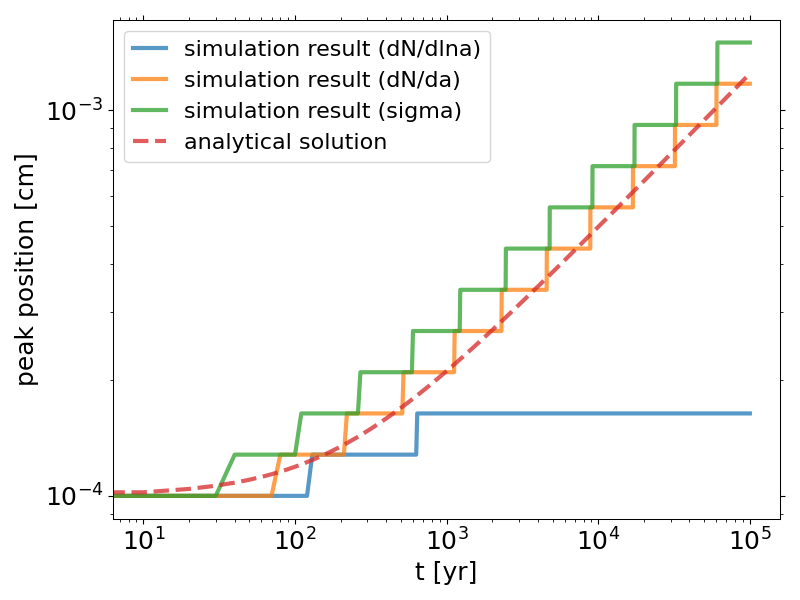

In [14]:
rho_d = r.Sigma_d / (np.sqrt(2*np.pi) * r.H_d[1])
fac = np.sqrt(12 * r.cgs_k_B * 196 / r.rho_m)
analy_a = lambda t, t0, a0 : (2.5 * rho_d / (r.rho_m * np.pi) * fac * (t - t0)*(u.yr.to(u.s)) + a0**2.5)**0.4

rxplt.plt_params('m'); fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(t, peak_Na, lw=3, alpha=0.75, label='simulation result (dN/dlna)')
ax.loglog(t, peak_dNda, lw=3, alpha=0.75, label='simulation result (dN/da)')
ax.loglog(t, peak_sigma, lw=3, alpha=0.75, label='simulation result (sigma)')
ax.loglog(t, analy_a(t, 0, a[1]), '--', lw=3, alpha=0.75, label='analytical solution')
ax.set(xlabel=r't [yr]', ylabel='peak position [cm]');
ax.legend(loc='best'); fig.tight_layout()